In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import os
import lightgbm as lgb

from typing import Union
import gc
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

gc.collect()
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

0

In [3]:

def Upcoming(calendar, NWDays):
    upcomingEvent= []
    dayEvent = []
    NWDay = []
    events = calendar["event_name_1"].tolist()
    events2 = calendar["event_name_2"].tolist()
    Day = calendar["weekday"].tolist()
    days = len(events)
    for i in range(days):
        ev1, ev2, day = firstEvent(events,events2)
        upcomingEvent.append(ev1)
        dayEvent.append(day)
        if (day == 0) and ((ev1 in NWDays) or (ev2 in NWDays)) or (Day[i] == "Saturday") or (Day[i] == "Sunday") :
            NWDay.append(True)
        else:
            NWDay.append(False)
        events.pop(0)
        events2.pop(0)
    calendar["NWD"] = NWDay
    calendar["upcomingEvent"] = upcomingEvent
    return calendar

import math
def firstEvent(events, events2):
    events = pd.Series(events)
    events2 = pd.Series(events2)
    ind = events.index.get_loc(events.first_valid_index()) 
    ind2 = events2.index.get_loc(events2.first_valid_index()) 
    event = events[ind]
    if ind == ind2:
        event2 = events2[ind]
    else:
        event2 = event
        
    return event, event2, ind

In [4]:
path = ""

calendar = pd.read_csv(os.path.join(path, "calendar.csv"))
calendar["date"] = pd.to_datetime(calendar["date"])
from sklearn.preprocessing import OrdinalEncoder

NonWorking_days = ["NewYear", "IndependenceDay", "LaborDay", "MemorialDay", "Thanksgiving", "Christmas"]
def prep_calendar(df):
    df = Upcoming(df, NonWorking_days)
    df["quarter"] = getattr(df["date"].dt, "quarter").astype("int16")
    df = df.drop(["date","weekday", "year", "event_type_1", "event_type_2"], axis=1)
    df = df.assign(d = df.d.str[2:].astype(int))
    to_ordinal = ["event_name_1", "event_name_2", "upcomingEvent", "NWD"] 
    df[to_ordinal] = df[to_ordinal].fillna("1")
    df[to_ordinal] = OrdinalEncoder(dtype="int").fit_transform(df[to_ordinal]) + 1
    to_int8 = ["wday", "month"] + to_ordinal
    to_float32 = ["snap_CA", "snap_TX", "snap_WI"]
    df[to_int8] = df[to_int8].astype("int8")
    df[to_float32] = df[to_float32].astype("float32")
    return df
calendar = prep_calendar(calendar)

selling_prices = pd.read_csv(os.path.join(path, "sell_prices.csv"))
sample_submission = pd.read_csv(os.path.join(path, "sample_submission.csv"))
sales = pd.read_csv(os.path.join(path, "sales_train_validation.csv"))


In [5]:

from sklearn.model_selection import train_test_split

LAGS = [7, 14, 28] 
WINDOWS = [7, 14, 28]
FIRST = 1914
LENGTH = 28

def demand_features(df):
    """ Derive features from sales data and remove rows with missing values """
    
    for lag in LAGS:
        df[f'lag_t{lag}'] = df.groupby('id')['demand'].transform(lambda x: x.shift(lag)).astype("float32")
        for w in WINDOWS:
            df[f'rolling_mean_lag{lag}_w{w}'] = df.groupby('id')[f'lag_t{lag}'].transform(lambda x: x.rolling(w).mean()).astype("float32")
        
    return df

def demand_features_eval(df):
    """ Same as demand_features but for the step-by-step evaluation """
    out = df.groupby('id', sort=False).last()
    for lag in LAGS:
        out[f'lag_t{lag}'] = df.groupby('id', sort=False)['demand'].nth(-lag-1).astype("float16")
        for w in WINDOWS:
            out[f'rolling_mean_lag{lag}_w{w}'] = df.groupby('id', sort=False)['demand'].nth(list(range(-lag-w, -lag))).groupby('id', sort=False).mean().astype("float32")
    
    return out.reset_index()

def prep_data(df, drop_d=1000):
    """ Prepare model data sets """
    
    # Kick out old dates
    df = df.drop(["d_" + str(i+1) for i in range(drop_d)], axis=1)

    # Reshape to long
    df = df.assign(id=df.id.str.replace("_validation", ""))
    df = df.reindex(columns=df.columns.tolist() + ["d_" + str(FIRST + i) for i in range(2 * LENGTH)])
    df = df.melt(id_vars=["id", "item_id", "store_id", "state_id", "dept_id", "cat_id"], var_name='d', value_name='demand')
    df = df.assign(d=df.d.str[2:].astype("int64"),
                   demand=df.demand.astype("float32"))
    
    
    Cols = df.columns
    gc.collect()
    # Add demand features
    df = demand_features(df)
    
    # Remove rows with NAs
    df = df[df.d > (drop_d + max(LAGS) + max(WINDOWS))]
 
    # Join calendar & prices
    df = df.merge(calendar, how="left", on="d")
    df = df.merge(selling_prices, how="left", on=["store_id", "item_id", "wm_yr_wk"])
    df = df.drop(["wm_yr_wk"], axis=1)
    
    #predict 28 days earlier
    df = df.drop_duplicates()
    df['d'] = df['d']+28
    
    # Ordinal encoding of remaining categorical fields
    for v in ["item_id", "store_id", "state_id", "dept_id", "cat_id"]:
        df[v] = OrdinalEncoder(dtype="int").fit_transform(df[[v]]).astype("int16") + 1
    
      
    # Determine list of covariables
    x = list(set(df.columns) - {'id', 'd', 'demand'})
    
    # Split into test, valid, train
    test = df[df.d >= FIRST - max(LAGS) - max(WINDOWS)]
    df = df[df.d < FIRST]

    xtrain, xvalid, ytrain, yvalid = train_test_split(df[x], df["demand"], test_size=0.1, shuffle=True, random_state=54)
    train = lgb.Dataset(xtrain, label = ytrain)
    valid = lgb.Dataset(xvalid, label = yvalid)
    return train, valid, test, x, xtrain, xvalid, ytrain, yvalid, df, df[Cols]

def fit_model(train, valid):
    """ Fit LightGBM model """
     
    params = {
        'metric': 'rmse',
        'objective': 'poisson',
        'seed': 200,
        'force_row_wise' : True,
        'learning_rate' : 0.1,
        'lambda': 0.1,
        'num_leaves': 77,
        'sub_row' : 0.7,
        'bagging_freq' : 1,
        'colsample_bytree': 0.65,
        'tree_learner' : 'feature'
    }
    


    fit = lgb.train(params, 
                    train, 
                    num_boost_round = 7000, #originally 2000, sped up for debug purposes
                    valid_sets = [valid], 
                    early_stopping_rounds =300,
                    verbose_eval = 100)
    
    lgb.plot_importance(fit, importance_type="gain", precision=0, height=0.5, figsize=(6, 10));
    
    return fit

def pred_to_csv(fit, test, x, cols=sample_submission.columns, file="submission.csv"):
    """ Calculate predictions and append to submission csv """
    
    # Recursive prediction
    for i, day in enumerate(np.arange(FIRST, FIRST + LENGTH)):
        test_day = demand_features_eval(test[(test.d <= day) & (test.d >= day - max(LAGS) - max(WINDOWS))])
        test.loc[test.d == day, "demand"] = fit.predict(test_day[x]) # https://www.kaggle.com/kyakovlev/m5-dark-magic
    test = test.assign(id=test.id + "_" + np.where(test.d < FIRST + LENGTH, "validation", "evaluation"),
                       F="F" + (test.d - FIRST + 1 - LENGTH * (test.d >= FIRST + LENGTH)).astype("str"))
    
    # Reshape
    submission = test.pivot(index="id", columns="F", values="demand").reset_index()[cols].fillna(1)
    
    # Export
    submission.to_csv(file, index=False)
    
    return test, submission

gc.collect()

0

Prepped
Training until validation scores don't improve for 300 rounds
[100]	valid_0's rmse: 2.21185
[200]	valid_0's rmse: 2.18084
[300]	valid_0's rmse: 2.16086
[400]	valid_0's rmse: 2.14717
[500]	valid_0's rmse: 2.14478
[600]	valid_0's rmse: 2.14026
[700]	valid_0's rmse: 2.13324
[800]	valid_0's rmse: 2.13104
[900]	valid_0's rmse: 2.12741
[1000]	valid_0's rmse: 2.12024
[1100]	valid_0's rmse: 2.11897
[1200]	valid_0's rmse: 2.11481
[1300]	valid_0's rmse: 2.11221
[1400]	valid_0's rmse: 2.1105
[1500]	valid_0's rmse: 2.10904
[1600]	valid_0's rmse: 2.10859
[1700]	valid_0's rmse: 2.10789
[1800]	valid_0's rmse: 2.10628
[1900]	valid_0's rmse: 2.10417
[2000]	valid_0's rmse: 2.10087
[2100]	valid_0's rmse: 2.0948
[2200]	valid_0's rmse: 2.0975
[2300]	valid_0's rmse: 2.0917
[2400]	valid_0's rmse: 2.08945
[2500]	valid_0's rmse: 2.08779
[2600]	valid_0's rmse: 2.08755
[2700]	valid_0's rmse: 2.0867
[2800]	valid_0's rmse: 2.08452
[2900]	valid_0's rmse: 2.0816
[3000]	valid_0's rmse: 2.08042
[3100]	valid_0'

84

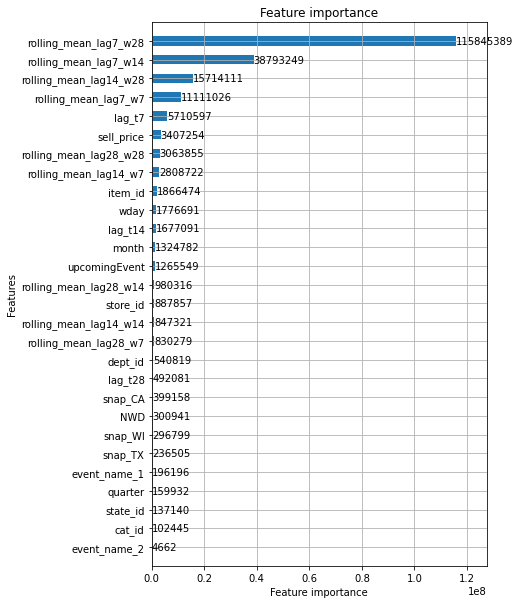

In [6]:
train, valid, test, x, xtrain, xvalid, ytrain, yvalid, df, df2 = prep_data(sales, 1000) # dropped 1500 for training, normally 1000
print("Prepped")
fit = fit_model(train, valid)
print("fitted")
sub, sub_pivoted = pred_to_csv(fit, test, x)
print("csv")
gc.collect()

In [7]:
Or = df2[(df2['d']>=1914) & (df2['d']<1914+28)] #original demand
Pred = test[(test['d']>=1914) & (test['d']<1914+28)] #predicted demand
or_pred = Or.merge(Pred, on=['id', 'd'], how='inner') #combined to 1 dataframe

gc.collect()

7003

In [8]:
from tqdm.notebook import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()


class WRMSSEEvaluator(object):

    def __init__(self, train_df: pd.DataFrame, valid_df: pd.DataFrame, 
                 calendar: pd.DataFrame, prices: pd.DataFrame):
        train_y = train_df.loc[:, train_df.columns.str.startswith('d_')]
        train_target_columns = train_y.columns.tolist()
        weight_columns = train_y.iloc[:, -28:].columns.tolist()

        train_df['all_id'] = 'all'  # for lv1 aggregation

        id_columns = train_df.loc[:, ~train_df.columns.str.startswith('d_')]\
                     .columns.tolist()
        valid_target_columns = valid_df.loc[:, valid_df.columns.str.startswith('d_')]\
                               .columns.tolist()

        if not all([c in valid_df.columns for c in id_columns]):
            valid_df = pd.concat([train_df[id_columns], valid_df], 
                                 axis=1, sort=False)

        self.train_df = train_df
        self.valid_df = valid_df
        self.calendar = calendar
        self.prices = prices

        self.weight_columns = weight_columns
        self.id_columns = id_columns
        self.valid_target_columns = valid_target_columns

        weight_df = self.get_weight_df()

        self.group_ids = (
            'all_id',
            'state_id',
            'store_id',
            'cat_id',
            'dept_id',
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            'item_id',
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
        )

        for i, group_id in enumerate(tqdm(self.group_ids)):
            train_y = train_df.groupby(group_id)[train_target_columns].sum()
            scale = []
            for _, row in train_y.iterrows():
                series = row.values[np.argmax(row.values != 0):]
                scale.append(((series[1:] - series[:-1]) ** 2).mean())
            setattr(self, f'lv{i + 1}_scale', np.array(scale))
            setattr(self, f'lv{i + 1}_train_df', train_y)
            setattr(self, f'lv{i + 1}_valid_df', valid_df.groupby(group_id)\
                    [valid_target_columns].sum())

            lv_weight = weight_df.groupby(group_id)[weight_columns].sum().sum(axis=1)
            setattr(self, f'lv{i + 1}_weight', lv_weight / lv_weight.sum())

    def get_weight_df(self) -> pd.DataFrame:
        day_to_week = self.calendar.set_index('d')['wm_yr_wk'].to_dict()
        weight_df = self.train_df[['item_id', 'store_id'] + self.weight_columns]\
                    .set_index(['item_id', 'store_id'])
        weight_df = weight_df.stack().reset_index()\
                   .rename(columns={'level_2': 'd', 0: 'value'})
        weight_df['wm_yr_wk'] = weight_df['d'].map(day_to_week)

        weight_df = weight_df.merge(self.prices, how='left',
                                    on=['item_id', 'store_id', 'wm_yr_wk'])
        weight_df['value'] = weight_df['value'] * weight_df['sell_price']
        weight_df = weight_df.set_index(['item_id', 'store_id', 'd'])\
                    .unstack(level=2)['value']\
                    .loc[zip(self.train_df.item_id, self.train_df.store_id), :]\
                    .reset_index(drop=True)
        weight_df = pd.concat([self.train_df[self.id_columns],
                               weight_df], axis=1, sort=False)
        return weight_df

    def rmsse(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        valid_y = getattr(self, f'lv{lv}_valid_df')
        score = ((valid_y - valid_preds) ** 2).mean(axis=1)
        scale = getattr(self, f'lv{lv}_scale')
        return (score / scale).map(np.sqrt) 

    def score(self, valid_preds: Union[pd.DataFrame, 
                                       np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape \
               == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, 
                                       columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], 
                                 valid_preds], axis=1, sort=False)

        all_scores = []
        for i, group_id in enumerate(self.group_ids):

            valid_preds_grp = valid_preds.groupby(group_id)[self.valid_target_columns].sum()
            setattr(self, f'lv{i + 1}_valid_preds', valid_preds_grp)
            
            lv_scores = self.rmsse(valid_preds_grp, i + 1)
            setattr(self, f'lv{i + 1}_scores', lv_scores)
            
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, 
                                  sort=False).prod(axis=1)
            
            all_scores.append(lv_scores.sum())
            
        self.all_scores = all_scores

        return np.mean(all_scores)

def create_viz_df(df,lv):
    
    df = df.T.reset_index()
    if lv in [6,7,8,9,11,12]:
        df.columns = [i[0] + '_' + i[1] if i != ('index','') else i[0] for i in df.columns]
    df = df.merge(calendar.loc[:, ['d','date']], how='left', 
                  left_on='index', right_on='d')
    df['date'] = pd.to_datetime(df.date)
    df = df.set_index('date')
    df = df.drop(['index', 'd'], axis=1)
    
    return df

def create_dashboard(evaluator):
    
    wrmsses = [np.mean(evaluator.all_scores)] + evaluator.all_scores
    labels = ['Overall'] + [f'Level {i}' for i in range(1, 13)]

    ## WRMSSE by Level
    plt.figure(figsize=(12,5))
    ax = sns.barplot(x=labels, y=wrmsses)
    ax.set(xlabel='', ylabel='WRMSSE')
    plt.title('WRMSSE by Level', fontsize=20, fontweight='bold')
    for index, val in enumerate(wrmsses):
        ax.text(index*1, val+.01, round(val,4), color='black', 
                ha="center")
        
    # configuration array for the charts
    n_rows = [1, 1, 4, 1, 3, 3, 3, 3, 3, 3, 3, 3]
    n_cols = [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
    width = [7, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]
    height = [4, 3, 12, 3, 9, 9, 9, 9, 9, 9, 9, 9]
    
    for i in range(1,13):
        
        scores = getattr(evaluator, f'lv{i}_scores')
        weights = getattr(evaluator, f'lv{i}_weight')
        
        if i > 1 and i < 9:
            if i < 7:
                fig, axs = plt.subplots(1, 2, figsize=(12, 3))
            else:
                fig, axs = plt.subplots(2, 1, figsize=(12, 8))
                
            ## RMSSE plot
            scores.plot.bar(width=.8, ax=axs[0], color='g')
            axs[0].set_title(f"RMSSE", size=14)
            axs[0].set(xlabel='', ylabel='RMSSE')
            if i >= 4:
                axs[0].tick_params(labelsize=8)
            for index, val in enumerate(scores):
                axs[0].text(index*1, val+.01, round(val,4), color='black', 
                            ha="center", fontsize=10 if i == 2 else 8)
            
            ## Weight plot
            weights.plot.bar(width=.8, ax=axs[1])
            axs[1].set_title(f"Weight", size=14)
            axs[1].set(xlabel='', ylabel='Weight')
            if i >= 4:
                axs[1].tick_params(labelsize=8)
            for index, val in enumerate(weights):
                axs[1].text(index*1, val+.01, round(val,2), color='black', 
                            ha="center", fontsize=10 if i == 2 else 8)
                    
            fig.suptitle(f'Level {i}: {evaluator.group_ids[i-1]}', size=24 ,
                         y=1.1, fontweight='bold')
            plt.tight_layout()
            plt.show()

        trn = create_viz_df(getattr(evaluator, f'lv{i}_train_df').iloc[:, -28*3:], i)
        val = create_viz_df(getattr(evaluator, f'lv{i}_valid_df'), i)
        pred = create_viz_df(getattr(evaluator, f'lv{i}_valid_preds'), i)

        n_cate = trn.shape[1] if i < 7 else 9

        fig, axs = plt.subplots(n_rows[i-1], n_cols[i-1], 
                                figsize=(width[i-1],height[i-1]))
        if i > 1:
            axs = axs.flatten()

        ## Time series plot
        for k in range(0, n_cate):

            ax = axs[k] if i > 1 else axs

            trn.iloc[:, k].plot(ax=ax, label='train')
            val.iloc[:, k].plot(ax=ax, label='valid')
            pred.iloc[:, k].plot(ax=ax, label='pred')
            ax.set_title(f"{trn.columns[k]}  RMSSE:{scores[k]:.4f}", size=14)
            ax.set(xlabel='', ylabel='sales')
            ax.tick_params(labelsize=8)
            ax.legend(loc='upper left', prop={'size': 10})

        if i == 1 or i >= 9:
            fig.suptitle(f'Level {i}: {evaluator.group_ids[i-1]}', size=24 , 
                         y=1.1, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
gc.collect()

0

In [9]:
   
train_df = sales.iloc[:, :-28]
valid_df = sales.iloc[:, -28:]
del calendar
calendar = pd.read_csv(os.path.join(path, "calendar.csv"))

valid_preds_id = train_df['id']
valid_preds_df = pd.DataFrame(valid_preds_id)
valid_preds_df = valid_preds_df.merge(sub_pivoted, on=['id'], how='inner')
cols =['id']
for i in range(28):
    cols.append('d_{}'.format(1886+i))
valid_preds_df.columns = cols
valid_preds_df = valid_preds_df.drop(columns='id')

evaluator = WRMSSEEvaluator(train_df, valid_df, calendar, selling_prices)
WRMSSEE = evaluator.score(valid_preds_df.values)
print(WRMSSEE)




0.519696204499468


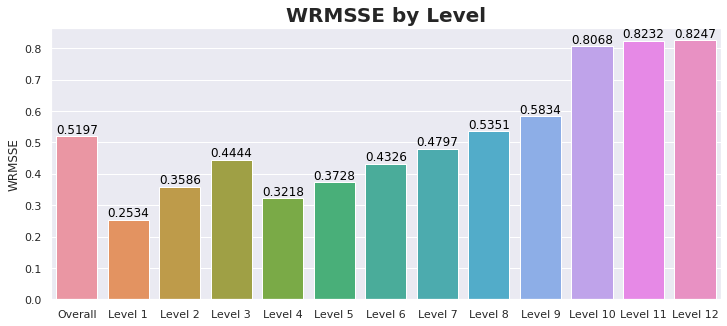

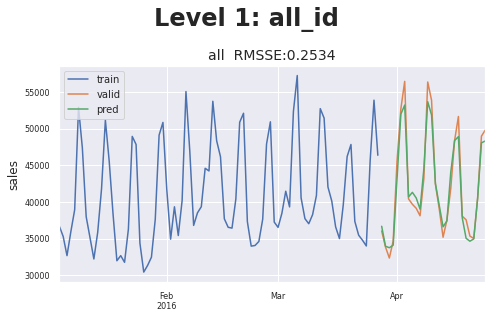

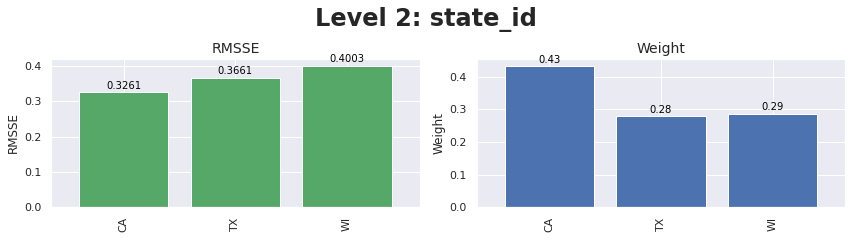

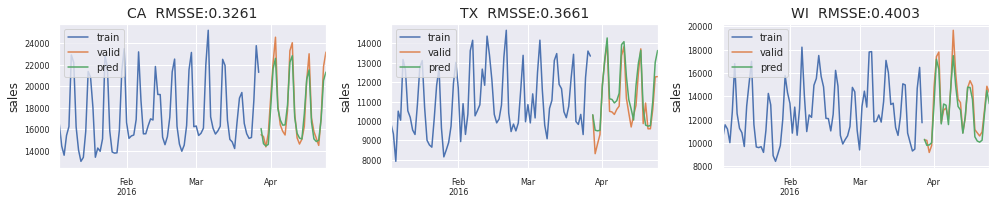

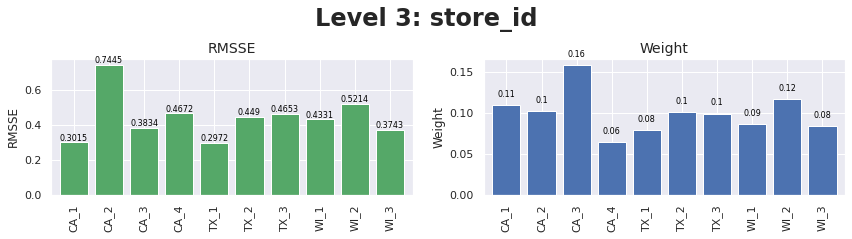

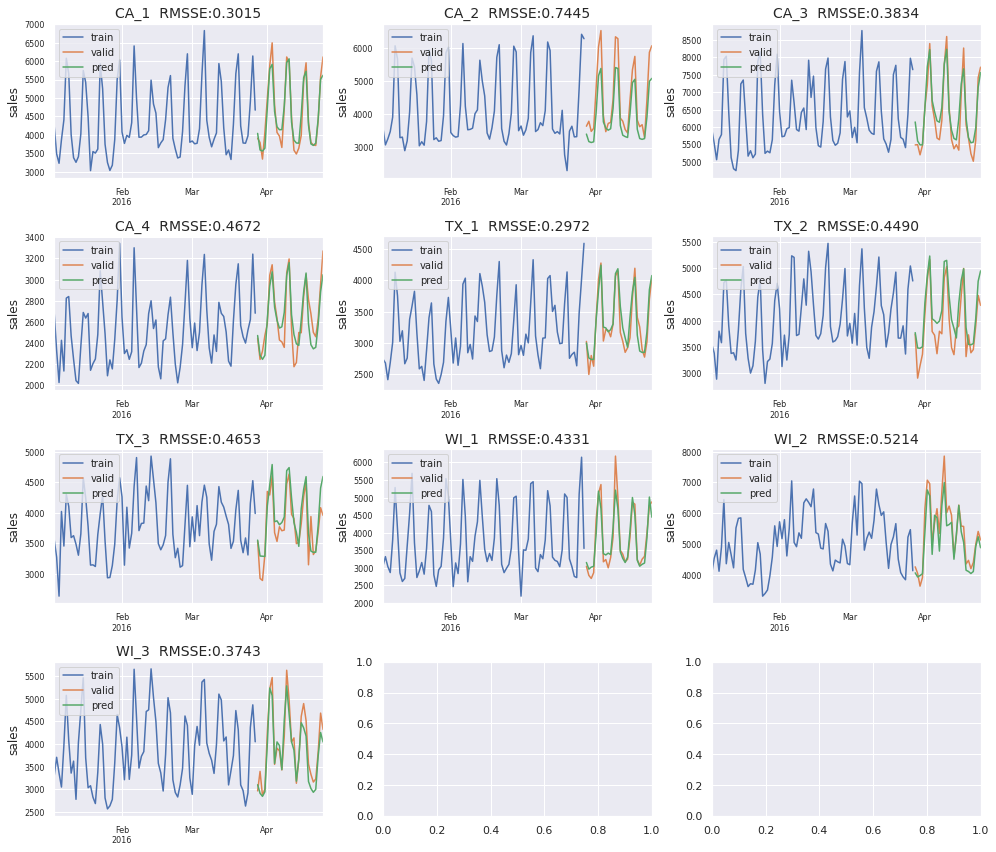

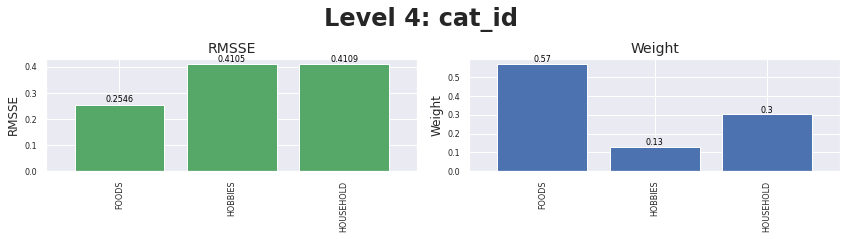

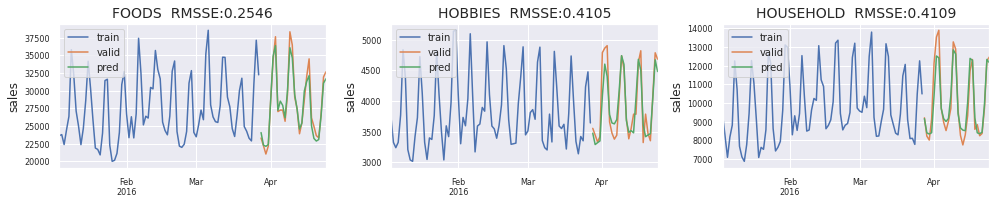

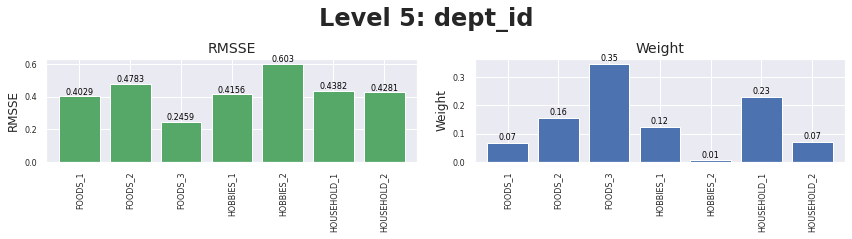

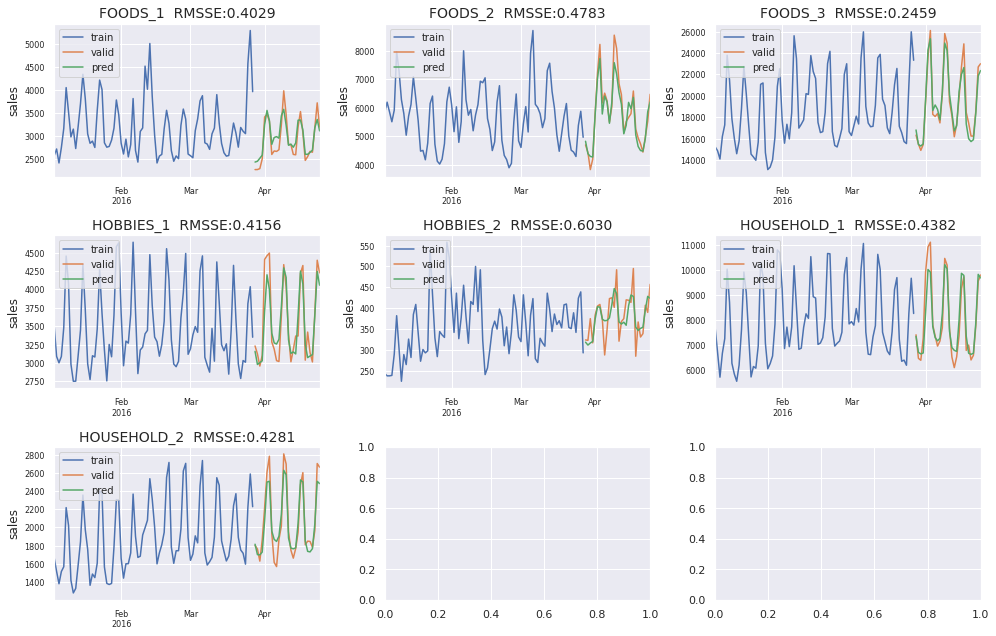

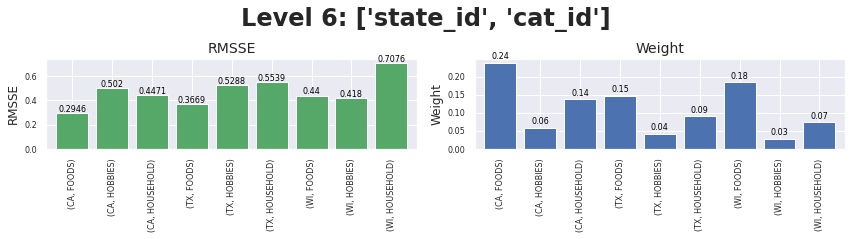

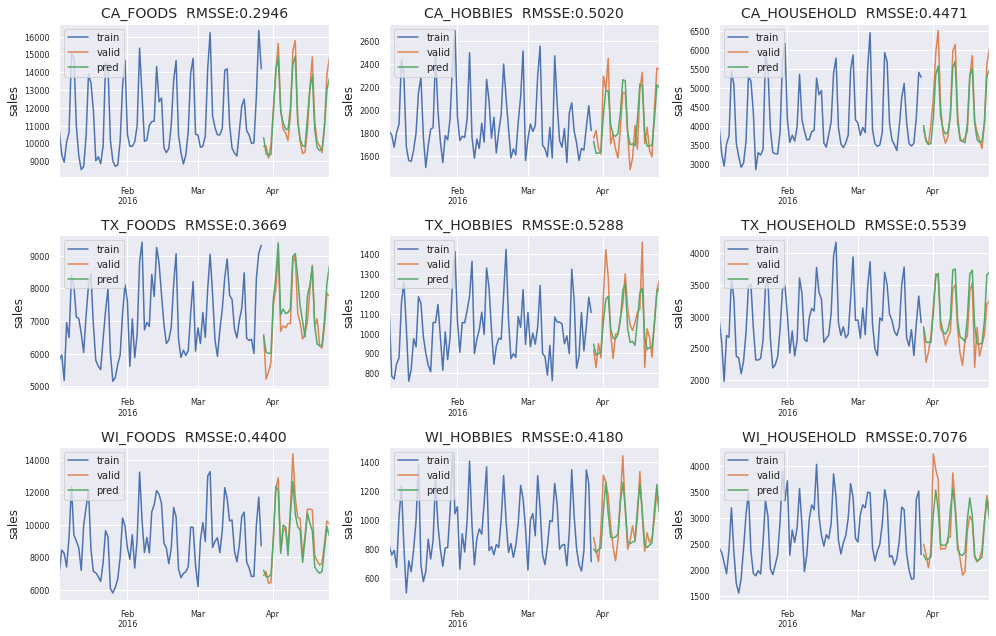

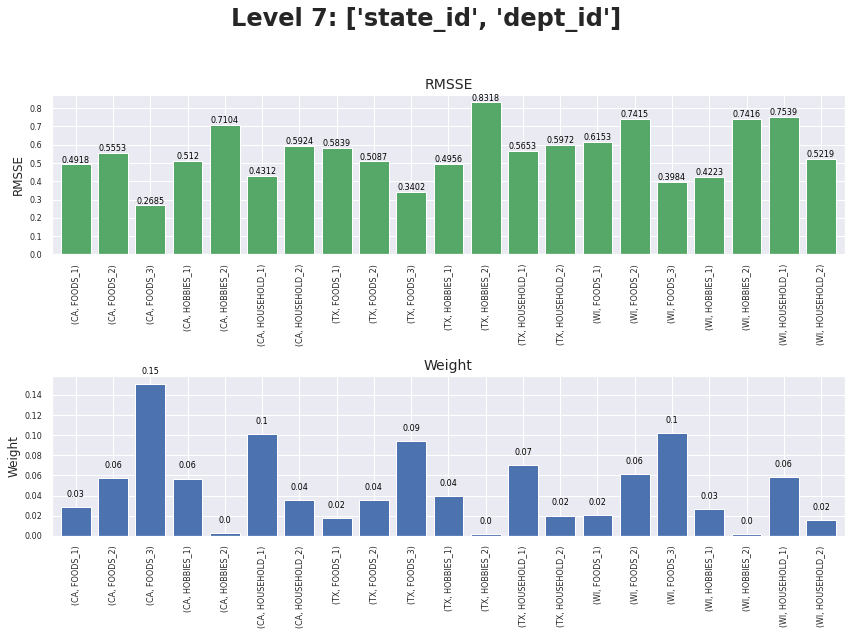

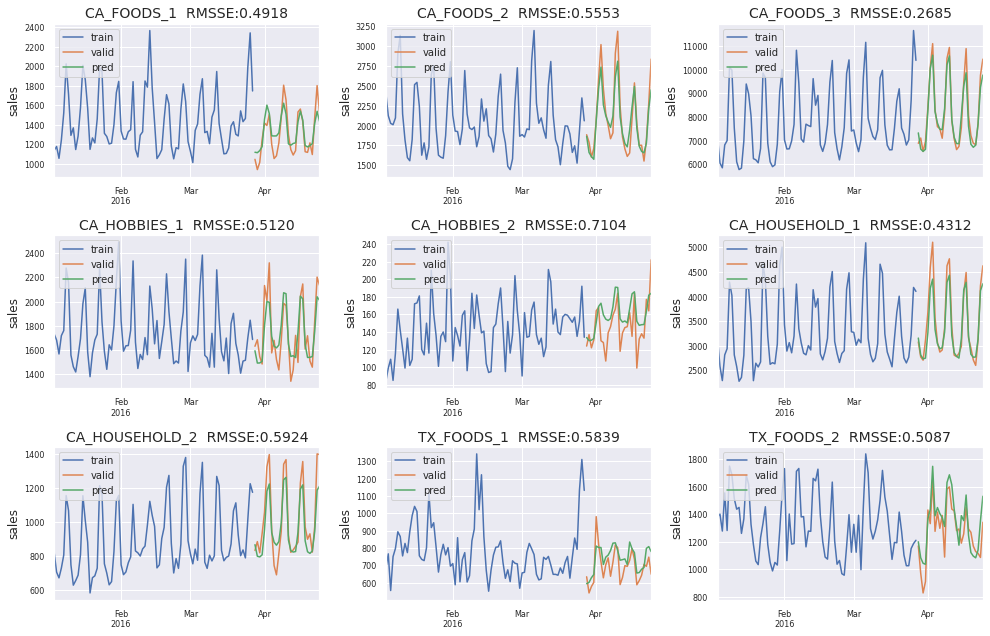

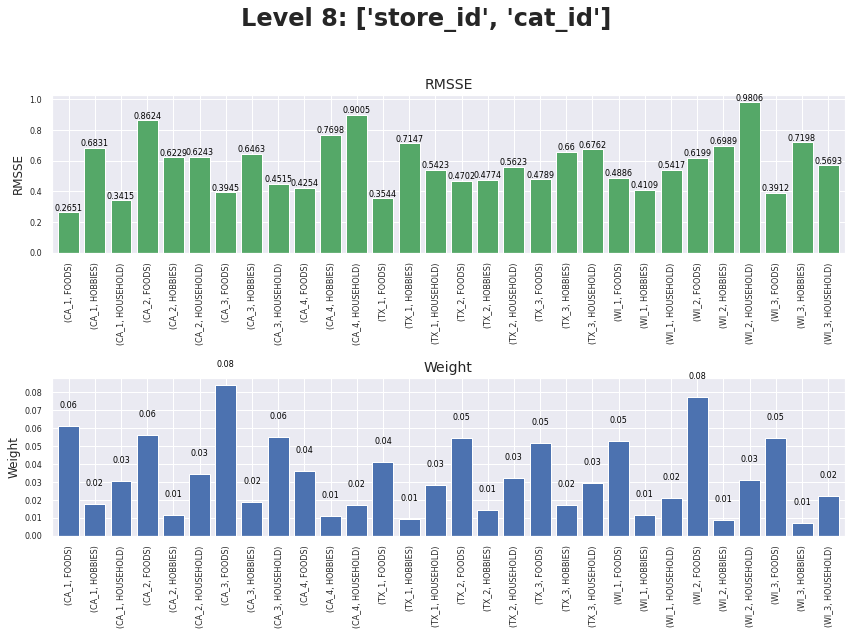

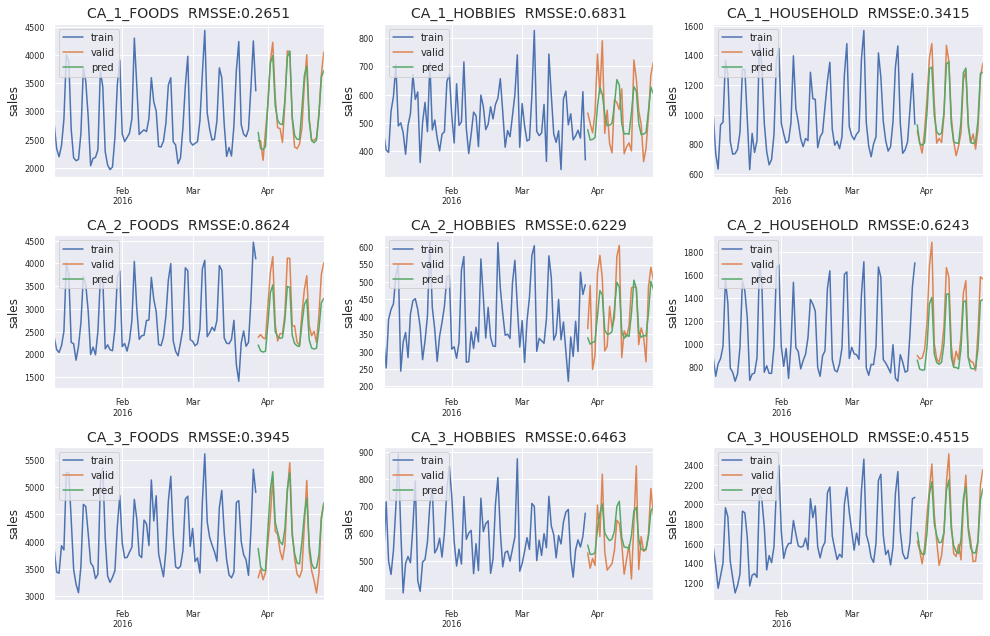

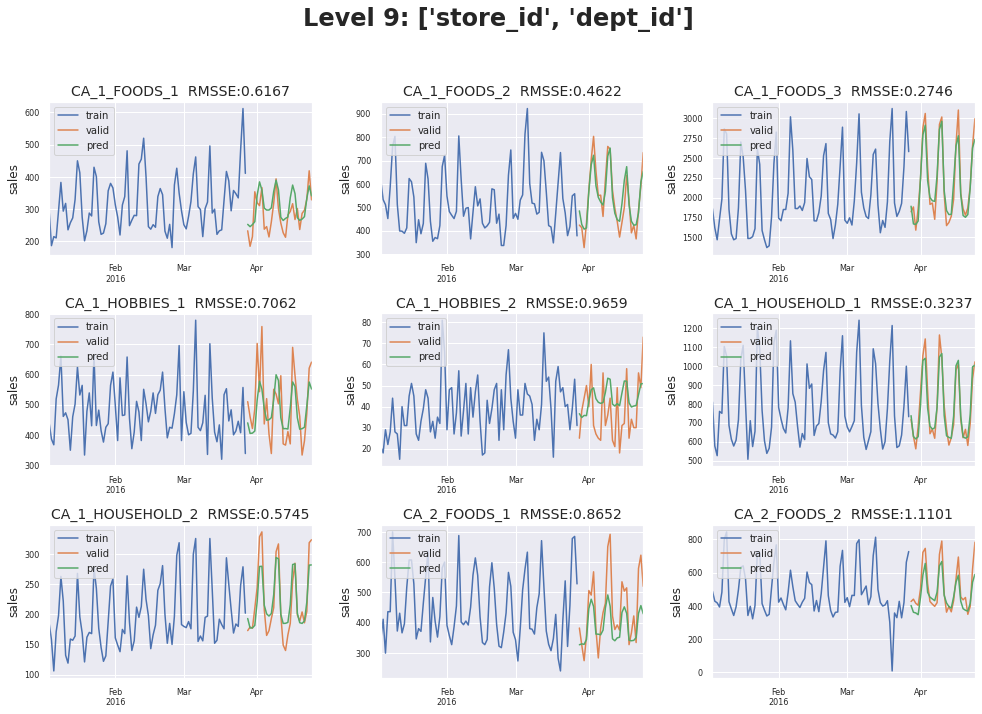

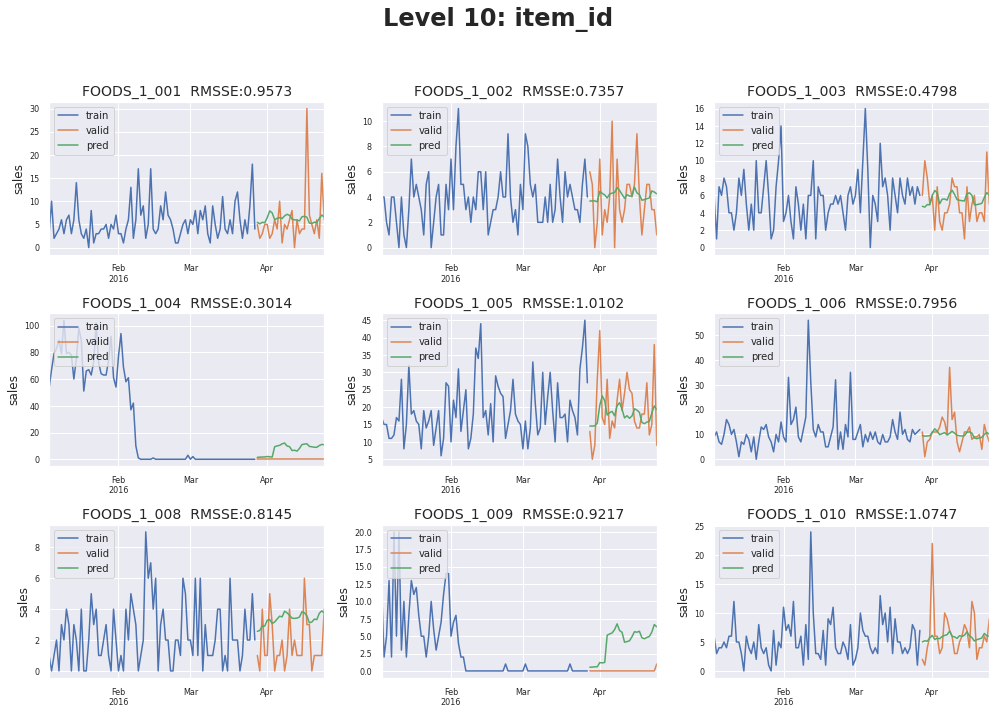

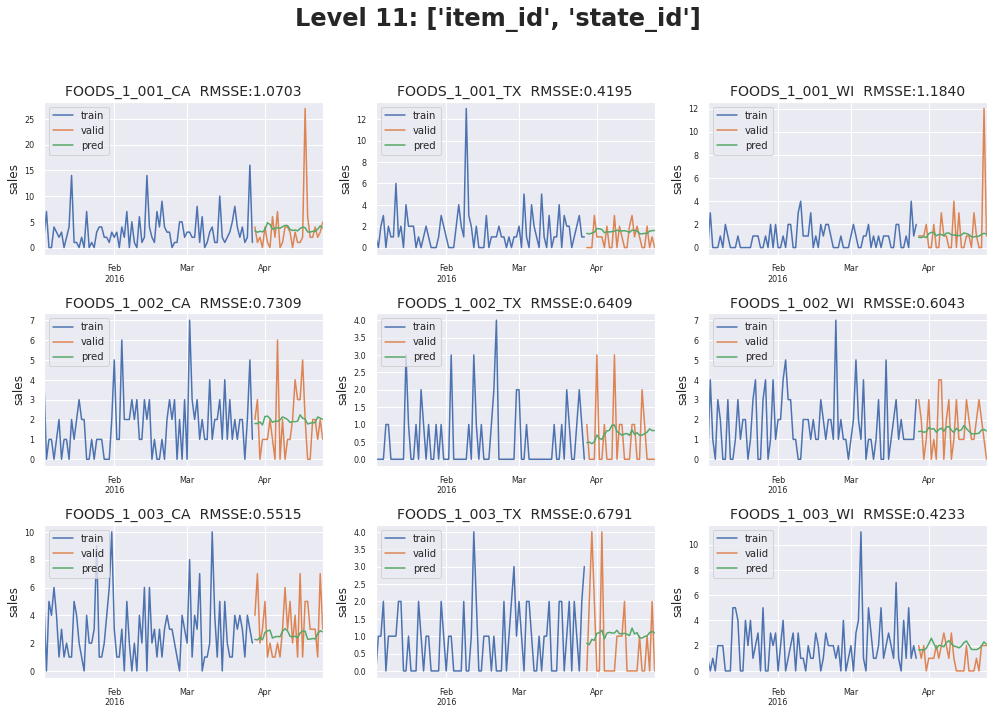

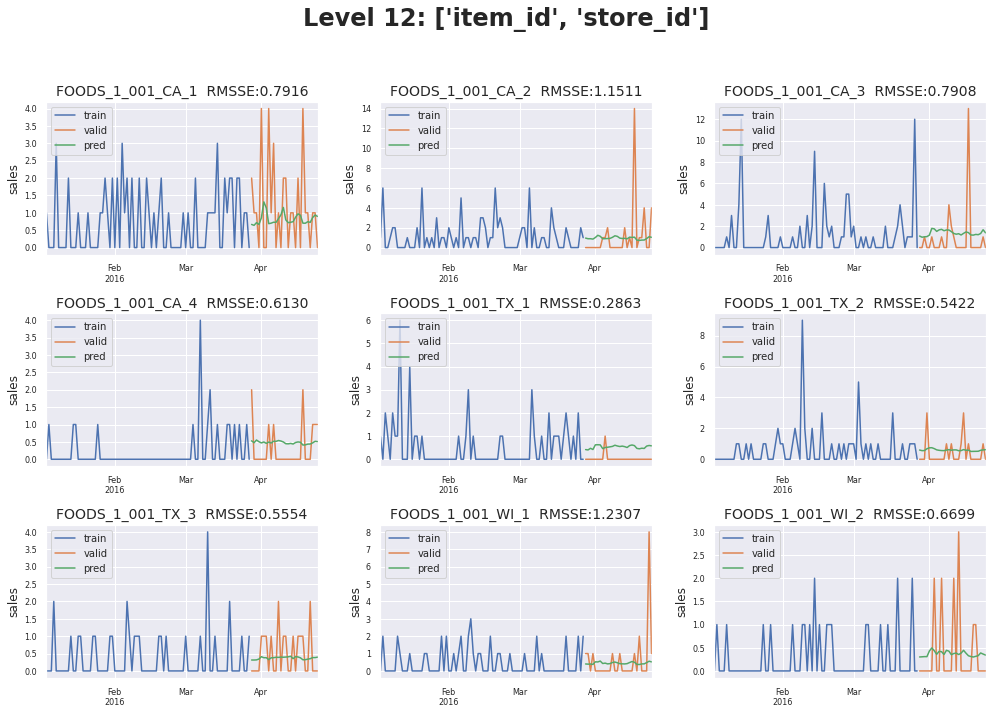

In [10]:
create_dashboard(evaluator)